In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
pip install split-folders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
########### splitting data ############
import splitfolders
splitfolders.ratio('/kaggle/input/audataset/AugmentedAlzheimerDataset', output="Inputs", seed=1345, ratio=(0.7,0.2,0.1))# seed was 1345
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

Copying files: 33984 files [03:30, 161.28 files/s]


In [4]:
# Paths
train_dir = '/kaggle/working/Inputs/train'  # Set path to train directory
test_dir = '/kaggle/working/Inputs/test'  # Set path to test directory

# Hyperparameters
batch_size = 32
epochs = 50
dropout_rate = 0.9
image_size = (128, 128)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 19032 images belonging to 4 classes.
Found 4756 images belonging to 4 classes.
Found 3400 images belonging to 4 classes.


In [5]:

# Model Definition
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128,128, 3))
#base_model.trainable = False  # Freeze the base model
for layers in base_model.layers[:100]:
    layers.trainable = False
for layers in base_model.layers[100:]:
    layers.trainable = True


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(dropout_rate),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732261401.574167     122 service.cc:145] XLA service 0x792b9c002e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732261401.574227     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732261401.574232     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732261460.645197     122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_52', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1732261460.725

595/595 ━━━━━━━━━━━━━━━━━━━━ 363s 388ms/step - accuracy: 0.3302 - loss: 1.4725 - val_accuracy: 0.3301 - val_loss: 220.0999 - learning_rate: 0.0010
Epoch 2/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 166s 277ms/step - accuracy: 0.5464 - loss: 0.9729 - val_accuracy: 0.6190 - val_loss: 0.9483 - learning_rate: 0.0010
Epoch 3/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 165s 275ms/step - accuracy: 0.5849 - loss: 0.8919 - val_accuracy: 0.6150 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 4/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 166s 276ms/step - accuracy: 0.6376 - loss: 0.7769 - val_accuracy: 0.5982 - val_loss: 0.9163 - learning_rate: 0.0010
Epoch 5/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 165s 276ms/step - accuracy: 0.6560 - loss: 0.7660 - val_accuracy: 0.6678 - val_loss: 0.7191 - learning_rate: 0.0010
Epoch 6/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 166s 276ms/step - accuracy: 0.6745 - loss: 0.7119 - val_accuracy: 0.5664 - val_loss: 1.3664 - learning_rate: 0.0010
Epoch 7/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 166s 276ms/step - accuracy: 0.687

In [7]:
# Evaluation
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.95, Test Accuracy: 0.96


In [8]:
# Classification Report and Confusion Matrix
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      0.99      0.99       896
ModerateDemented       1.00      1.00      1.00       648
     NonDemented       0.93      0.94      0.94       960
VeryMildDemented       0.93      0.93      0.93       896

        accuracy                           0.96      3400
       macro avg       0.97      0.96      0.96      3400
    weighted avg       0.96      0.96      0.96      3400



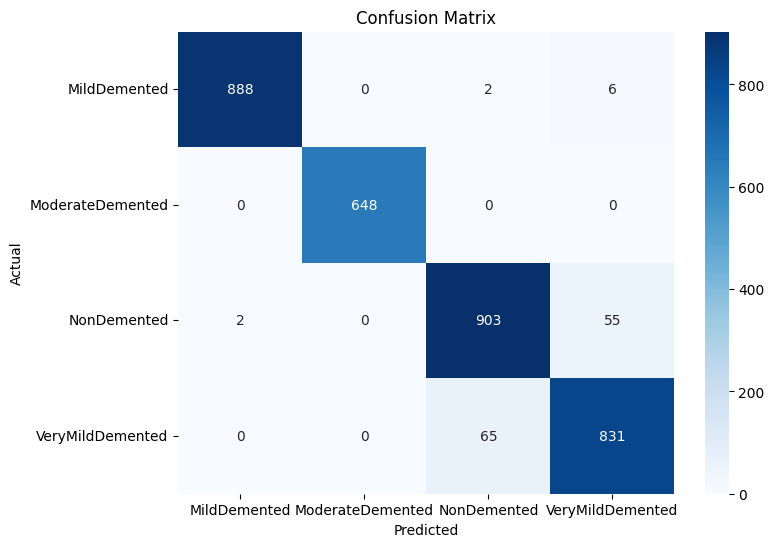

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

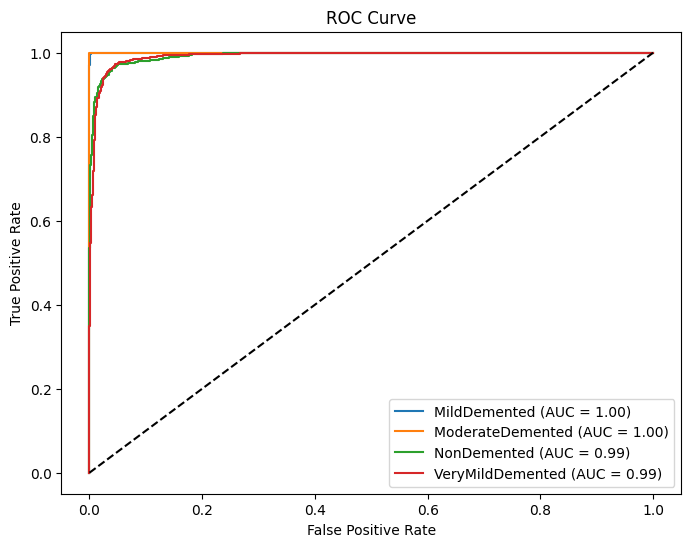

In [10]:
# ROC Curve and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

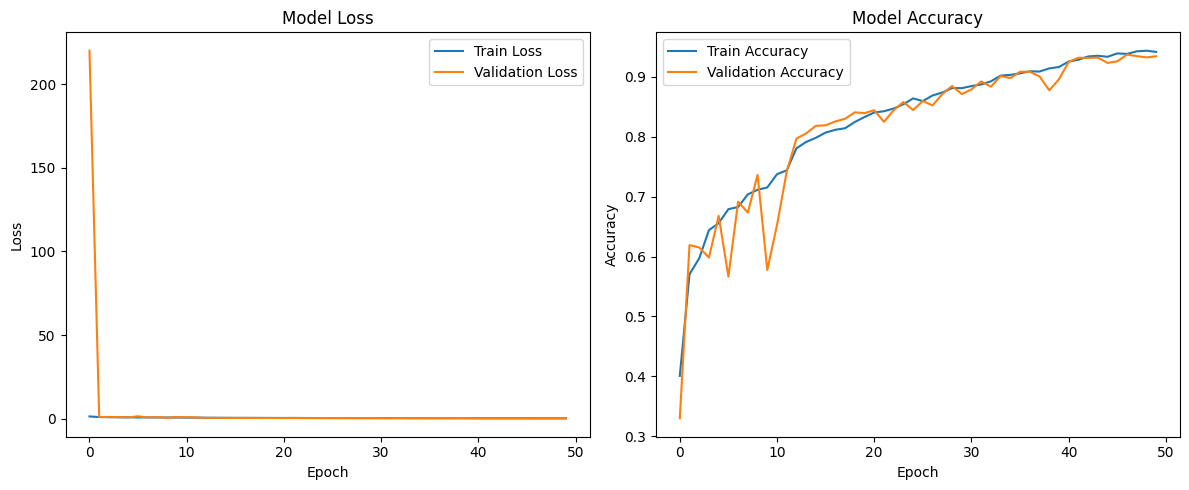

In [11]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()